In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pylab import *
import csv,os, glob
from sklearn.decomposition import PCA,IncrementalPCA
import random
import pickle

In [6]:
home_dir = "/gpfs/slac/staas/fs1/g/supercdms/tf/northwestern/users/franinsu/testRun3/"
processed_dir = home_dir+"processed/"
All_Traces = np.load(home_dir+"All_Traces.npz")
traces_sim_inner=All_Traces['traces_sim_inner']
traces_sim_outer=All_Traces['traces_sim_outer']
n_done_traces=All_Traces['n_done_traces']
traces_sim_inner=traces_sim_inner[:n_done_traces]
traces_sim_outer=traces_sim_outer[:n_done_traces]
print(traces_sim_inner.shape)
print(traces_sim_outer.shape)

All_OtherFeatures = np.load(home_dir+"All_OtherFeatures.npz")
otherFeatures=All_OtherFeatures['otherFeatures']
n_done_otherFeatures=All_OtherFeatures['n_done_otherFeatures']
otherFeatures=otherFeatures[:n_done_otherFeatures]
print(otherFeatures.shape)

(100000, 2048)
(100000, 2048)
(100000, 4)


In [7]:
noiseData = np.load(home_dir+"SomeNoise.npz")
traces_noise_inner=noiseData['traces_noise_inner']
traces_noise_outer=noiseData['traces_noise_outer']

In [8]:
# Combine traces
N = min([len(traces_sim_inner),len(traces_sim_outer),len(traces_noise_inner),len(traces_noise_outer)])

traces_comb_inner = np.empty((N,2048))
traces_comb_outer = np.empty((N,2048))
otherFeatures = otherFeatures[:N]
start_bins = np.empty((N,1))
random.seed(300)
for i in range(N):
    traces_sim_inner_padded = np.pad(traces_sim_inner[i],(2048,1024), 'constant')
    traces_sim_outer_padded = np.pad(traces_sim_outer[i],(2048,1024), 'constant')
    shift = random.randint(0, 2048+1024)
    traces_sim_inner_shifted = traces_sim_inner_padded[shift:shift+2048]
    traces_sim_outer_shifted = traces_sim_outer_padded[shift:shift+2048]
    traces_comb_inner[i] = traces_sim_inner_shifted+traces_noise_inner[i]
    traces_comb_outer[i] = traces_sim_outer_shifted+traces_noise_outer[i]
    start_bins[i] = 256-shift+2048

print(traces_comb_inner.shape)
print(traces_comb_outer.shape)

(40000, 2048)
(40000, 2048)


(38274, 2048)
(38274, 2048)


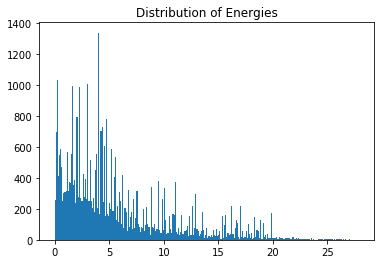

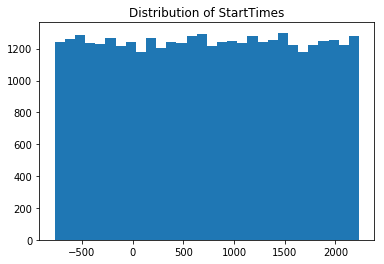

In [9]:
N0 = otherFeatures[:,0].shape[0]
exc = np.zeros(N0,dtype=int)
f, m = 0.75,0.2
exc[:round(f*N0)] = otherFeatures[:round(f*N0),0]<=m
#idx = np.arange(N0)*inc
idx = np.where(1-exc)

otherFeatures = otherFeatures[idx]
traces_comb_inner = traces_comb_inner[idx]
traces_comb_outer = traces_comb_outer[idx]
start_bins = start_bins[idx]

print(traces_comb_inner.shape)
print(traces_comb_outer.shape)

plt.hist(otherFeatures[:,0],bins=np.arange(0,28,0.1))
plt.title("Distribution of Energies")
plt.show()
plt.figure()
plt.hist(start_bins,bins=np.arange(min(start_bins[:,0]),max(start_bins[:,0]),100))
plt.title("Distribution of StartTimes")
plt.show()

In [10]:
def plot_history_time(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title("Final MAE Valid: {:7.2f} [time]".format(np.array(history.history['val_time_metric'])[-1]*Yrange[0]))
    plt.plot(history.epoch, np.array(history.history['time_metric']),
    label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_time_metric']),
    label = 'Val loss')
    plt.legend()
    plt.ylim([0, 
              max(
                  max(np.array(history.history['time_metric'])),
                  max(np.array(history.history['val_time_metric']))
              )])
def plotPred(X,Y,E,Yrange):
    Y_pred_s = model.predict(X)
    Y_pred_s = Y_pred_s*Yrange
    Y_test_s = Y*Yrange
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(30,6))

    ax1.plot(Y_test_s,Y_pred_s,"g.",markersize=4)
    ax1.plot(np.arange(2048),np.arange(2048),color='black')
    ax1.ylim([0,max(Y_pred_s)])
    
    mae = np.abs(Y_test_s-Y_pred_s)
    
    #ax2.title("MAE vs StartTime")
    ax2.plot(Y_test_s,mae,"r.",markersize=2)
    ax2.axhline(np.mean(mae),color='black')
    ax2.ylim([0,max(Y_pred_s)])
    
    #ax3.title("MAE vs Energy")
    ax3.plot(E,mae,"b.",markersize=2)
    ax3.axhline(np.mean(mae),color='black')

Size train: 23890
Size dev: 2389
Size test: 1257


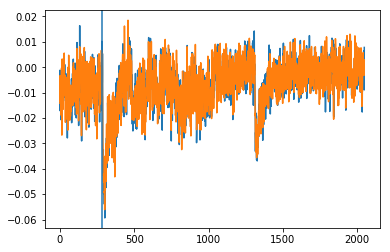

In [11]:
X = np.hstack((traces_comb_inner,traces_comb_outer))
# eventually we will the following, but for now we will try to focus on time
Y = np.hstack((start_bins, otherFeatures[:,0:1]))
np.random.seed(229)
d=0
downsample_factor = 1
closer = (start_bins >= 0-d) & (start_bins < 2048+d) & (otherFeatures[:,0:1]<=20)
#Y = np.squeeze(start_bins[closer])
X = X[np.squeeze(closer)]
Y = Y[np.squeeze(closer)]
X = np.array([np.mean(x.reshape(-1, downsample_factor,2), 1) for x in X])
plot(X[5])
axvline(Y[5,0]/downsample_factor/2)
#Ymin= np.min(Y)
#Ymax= np.max(Y)+1
Yrange = np.array([2048,20])# Ymax-Ymin
Y = Y/Yrange #(Y-Ymin)/Yrange
N=len(X)
m_train = round(.95*N)
m_dev =  round(.1*m_train)
idx = np.random.permutation(N)
X_train, X_test = X[idx[:m_train]], X[idx[m_train:]]
Y_train, Y_test = Y[idx[:m_train]], Y[idx[m_train:]]
#dev is subset of train but isn't actually used in training
X_dev, Y_dev  = X_train[-m_dev:], Y_train[-m_dev:]
print("Size train:",X_train.shape[0])
print("Size dev:",X_dev.shape[0])
print("Size test:", X_test.shape[0])

0: 0.119428, 0.057842
1: 0.073775, 0.049359
2: 0.068388, 0.048065
3: 0.066170, 0.035274
4: 0.051448, 0.040020
5: 0.042398, 0.039897
6: 0.037729, 0.035562
7: 0.037923, 0.033621
8: 0.030875, 0.033697
9: 0.033909, 0.035649
10: 0.034380, 0.034521
11: 0.023520, 0.018210
12: 0.032549, 0.040987
13: 0.024709, 0.032986
14: 0.022264, 0.022103
15: 0.021915, 0.033689
16: 0.021967, 0.035062
17: 0.025009, 0.026311
18: 0.022420, 0.025054
19: 0.018273, 0.027171
20: 0.019856, 0.030253
21: 0.020833, 0.029083
22: 0.019334, 0.031019
23: 0.014224, 0.030041
24: 0.015130, 0.033989
25: 0.018696, 0.035865
26: 0.016938, 0.027128
27: 0.014126, 0.032715
28: 0.018990, 0.035283
29: 0.019146, 0.037165
30: 0.012445, 0.027119
31: 0.012454, 0.036274
32: 0.013135, 0.033379
33: 0.011428, 0.038572
34: 0.019954, 0.027321
35: 0.015113, 0.031444
36: 0.012147, 0.034667
37: 0.012792, 0.031409
38: 0.013863, 0.032244
39: 0.015738, 0.031574
40: 0.010971, 0.030059
41: 0.010566, 0.027950
42: 0.012022, 0.032391
43: 0.014730, 0.02761

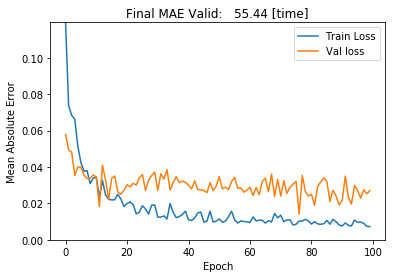

In [12]:
act = 'relu'
#init = 'random_uniform'
init = tf.contrib.layers.xavier_initializer()
#init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2, seed=229) #this is an edit
#init = None
reg = None
dropout_rate = 0.1
def time_metric(y_true, y_pred):
    return np.abs(y_true-y_pred)[0]
def energy_metric(y_true, y_pred):
    return np.abs(y_true-y_pred)[1]
def build_model():
    model = keras.Sequential([
        keras.layers.Conv1D (kernel_size = (4), filters = 64, strides=(1), 
                             input_shape=(X_train.shape[1:]), activation=act,
                             kernel_initializer=init,kernel_regularizer=reg),
        #keras.layers.Dropout(dropout_rate),
        keras.layers.MaxPooling1D(pool_size = (2), strides=(2)),
        keras.layers.Conv1D (kernel_size = (4), filters = 32, strides=(1), activation=act,
                             kernel_initializer=init,kernel_regularizer=reg),
        #keras.layers.Dropout(dropout_rate),
        keras.layers.MaxPooling1D(pool_size = (2), strides=(2)),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation=act,
                           kernel_initializer=init,kernel_regularizer=reg),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(256, activation=act,
                           kernel_initializer=init,kernel_regularizer=reg),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(128, activation=act,
                           kernel_initializer=init,kernel_regularizer=reg),
        #keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation=act,
                           kernel_initializer=init,kernel_regularizer=reg),
        #keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid',
                           kernel_initializer=None,kernel_regularizer=reg)
    ])
    optimizer = tf.train.AdamOptimizer(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[time_metric])
    return model
model = build_model()
all_logs = []
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    #if epoch % 10 == 0: print(epoch,end='')
    print("%d: %f, %f" %(epoch,logs['time_metric'],logs['val_time_metric']))
    all_logs.append(logs)
EPOCHS = 100
# Store training stats
history = model.fit(X_train, Y_train[:,0], epochs=EPOCHS,
                    validation_split=0.1, verbose=0,
                    callbacks=[PrintDot()])
plot_history_time(history)